In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [3]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [4]:
img_dir = os.getcwd() + '\images'
print(img_dir)

c:\Users\schli\OneDrive\SP23\ECE_561\Darts\images


In [5]:
print(extract_info_from_xml(os.path.join("XML", "20_2_1.xml")))

{'bboxes': [{'class': 'Dart', 'xmin': 371, 'ymin': 5, 'xmax': 423, 'ymax': 94}, {'class': '20_2', 'xmin': 386, 'ymin': 12, 'xmax': 404, 'ymax': 27}], 'filename': '20_2_1.jpg', 'image_size': (720, 480, 3)}


In [6]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"Dart": 0,
                           "Tip": 1
                           }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            if b["class"] != "Dart":
                b["class"] = "Tip"
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [7]:
print(class_name_to_id_mapping)

{'Dart': 0, 'Tip': 1}


In [8]:
# Get the annotations
annotations = [os.path.join('XML', x) for x in os.listdir('XML') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
print(annotations)

100%|██████████| 447/447 [00:00<00:00, 1996.38it/s]

['annotations\\0_0_0.txt', 'annotations\\0_0_1.txt', 'annotations\\0_0_12.txt', 'annotations\\0_0_13.txt', 'annotations\\0_0_14.txt', 'annotations\\0_0_2.txt', 'annotations\\0_0_3.txt', 'annotations\\0_0_4.txt', 'annotations\\0_0_5.txt', 'annotations\\0_0_6.txt', 'annotations\\0_0_7.txt', 'annotations\\0_0_8.txt', 'annotations\\0_0_9.txt', 'annotations\\10_1_0.txt', 'annotations\\10_1_1.txt', 'annotations\\10_1_10.txt', 'annotations\\10_1_2.txt', 'annotations\\10_1_3.txt', 'annotations\\10_1_4.txt', 'annotations\\10_1_5.txt', 'annotations\\10_1_6.txt', 'annotations\\10_1_7.txt', 'annotations\\10_1_8.txt', 'annotations\\10_1_9.txt', 'annotations\\10_2_0.txt', 'annotations\\10_2_1.txt', 'annotations\\10_2_2.txt', 'annotations\\10_2_3.txt', 'annotations\\10_3_0.txt', 'annotations\\10_3_1.txt', 'annotations\\10_3_2.txt', 'annotations\\10_3_3.txt', 'annotations\\11_1_0.txt', 'annotations\\11_1_1.txt', 'annotations\\11_1_10.txt', 'annotations\\11_1_2.txt', 'annotations\\11_1_3.txt', 'annotat

annotations\6_1_6.txt
images\6_1_6.jpg


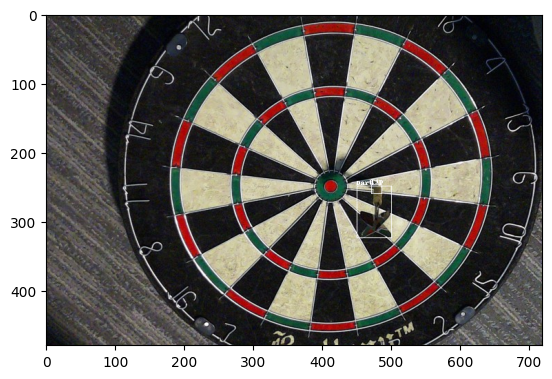

In [11]:


class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
print(annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations","images").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [12]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [13]:
if not os.path.exists("images/train/"):
    os.makedirs("images/train/")
if not os.path.exists("images/val/"):
    os.makedirs("images/val/")
if not os.path.exists("images/test/"):
    os.makedirs("images/test/")
if not os.path.exists("annotations/train/"):
    os.makedirs("annotations/train/")
if not os.path.exists("annotations/val/"):
    os.makedirs("annotations/val/")
if not os.path.exists("annotations/test/"):
    os.makedirs("annotations/test/")

In [14]:
for image in train_images:
    shutil.move(image, "images/train/")

In [15]:
for image in val_images:
    shutil.move(image, "images/val/")
for image in test_images:
    shutil.move(image, "images/test/")
for annotation in train_annotations:
    shutil.move(annotation, "annotations/train/")
for annotation in val_annotations:
    shutil.move(annotation, "annotations/val/")
for annotation in test_annotations:
    shutil.move(annotation, "annotations/test/")